## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

## Data preparation

In [3]:
# Parameters to choose:

# Minimum number of movies to consider a country,language or genre
Min_count_count = 20
Min_lang_count = 20
Min_genre_count = 20

# Sucess threshold for a movie to be considered sucessful on the normalized revenue
Sucess_revenue_threshold = 1.5


### Movie preparation

In [4]:
def movie_data_processing():
    movies = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

    movies.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
    movies.drop('Freebase movie ID', axis=1, inplace=True)
    movies["Movie languages"]=movies["Movie languages"].map(lambda x: set(ast.literal_eval(x).values()))
    movies["Movie countries"]=movies["Movie countries"].map(lambda x: set(ast.literal_eval(x).values()))
    movies['Movie genres']=movies['Movie genres'].map(lambda x: set(ast.literal_eval(x).values()))

    return movies
movies = movie_data_processing()

In [5]:
def process_dict_columns(movies):
    union_lang = set().union(*movies["Movie languages"])
    union_count = set().union(*movies['Movie countries'])
    union_genres = set().union(*movies['Movie genres'])

    print("Number of languages: ", len(union_lang))
    print("Number of countries: ", len(union_count))
    print("Number of genres: ", len(union_genres))



    lang_count = {}
    for lang in union_lang:
        lang_count[lang] = 0
    for lang in movies["Movie languages"]:
        for l in lang:
            lang_count[l] += 1
    lang_count = pd.DataFrame.from_dict(lang_count, orient='index', columns=['Count'])
    lang_count.sort_values(by=['Count'], ascending=False, inplace=True)


    lang_count = lang_count[lang_count['Count'] > Min_lang_count]
    print(f"Number of languages with more than {Min_lang_count} movies: ", len(lang_count))


    genre_count = {}
    for genre in union_genres:
        genre_count[genre] = 0
    for genre in movies['Movie genres']:
        for g in genre:
            genre_count[g] += 1
    genre_count = pd.DataFrame.from_dict(genre_count, orient='index', columns=['Count'])
    genre_count.sort_values(by=['Count'], ascending=False, inplace=True)


    genre_count = genre_count[genre_count['Count'] > Min_genre_count]
    print(f"Number of genres with more than {Min_genre_count} movies: ", len(genre_count))

    count_count = {}
    for count in union_count:
        count_count[count] = 0
    for count in movies['Movie countries']:
        for c in count:
            count_count[c] += 1
    count_count = pd.DataFrame.from_dict(count_count, orient='index', columns=['Count'])
    count_count.sort_values(by=['Count'], ascending=False, inplace=True)



    count_count = count_count[count_count['Count'] > Min_count_count]
    print(f"Number of countries with more than {Min_count_count} movies: ", len(count_count))

        
    movies["Movie languages"] = movies["Movie languages"].map(lambda x: set([l for l in x if l in lang_count.index]))
    movies["Movie countries"] = movies["Movie countries"].map(lambda x: set([c for c in x if c in count_count.index]))
    movies["Movie genres"] = movies["Movie genres"].map(lambda x: set([g for g in x if g in genre_count.index]))

    movies.drop(movies[movies["Movie languages"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie countries"].map(lambda x: len(x)) == 0].index, inplace=True)
    movies.drop(movies[movies["Movie genres"].map(lambda x: len(x)) == 0].index, inplace=True)
    return movies

movies = process_dict_columns(movies)

Number of languages:  207
Number of countries:  147
Number of genres:  363
Number of languages with more than 20 movies:  81
Number of genres with more than 20 movies:  245
Number of countries with more than 20 movies:  88


In [6]:
## CAREFUL This will make that many films will be published the 1st of January
def modify_movie_release_date(movies):
    movies.drop(movies[movies['Movie release date'].map(lambda x: type(x)!=str)].index, inplace=True)
    
    #little error in the date
    movies.loc[movies['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'

    movies["Movie release date"]=movies["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    return movies

movies = modify_movie_release_date(movies)

### Nan in revenue column

In [7]:
#drop when movie box office revenue is NaN
movies=movies.dropna(subset=['Movie box office revenue'])


In [8]:
tmdb = pd.read_csv('data/tmdb-movies.csv', sep=',', header=0)
joined = movies.join(tmdb.set_index('original_title'), on='Movie name', how='inner', lsuffix='_left', rsuffix='_right')

In [9]:
nbr = ((1-(joined['Movie box office revenue']>0)) & (joined['revenue']>0)).sum()
print(f"Number of movies with revenue in tmdb but not in our dataset: {nbr}")

Number of movies with revenue in tmdb but not in our dataset: 0


### Characters

In [10]:
def characters_data_process():
    characters = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
    characters = characters.rename(columns={0: 'Wikipedia movie ID', 1: 'Freebase movie ID', 2: 'Movie release date', 3: 'Character name', 4: 'Actor date of birth', 5: 'Actor gender', 6: 'Actor height (in meters)', 7: 'Actor ethnicity (Freebase ID)', 8: 'Actor name', 9: 'Actor age at movie release', 10: 'Freebase character/actor map ID', 11: 'Freebase character ID', 12: 'Freebase actor ID'})
    characters.drop('Freebase movie ID', axis=1, inplace=True)
    characters.drop('Freebase character/actor map ID', axis=1, inplace=True)
    characters.drop('Freebase character ID', axis=1, inplace=True)
    characters.drop('Freebase actor ID', axis=1, inplace=True)

    ## This one might be usefull
    characters.drop('Actor ethnicity (Freebase ID)', axis=1, inplace=True)


    characters["Movie release date"] = characters["Movie release date"].map(lambda x: x if len(str(x).split('-'))==3 else str(x).split('-')[0]+'-01-01')
    
    #little error in the date
    characters.loc[characters['Wikipedia movie ID']==29666067, 'Movie release date'] = '2010-12-02'
    
    characters.dropna(subset=['Character name',"Actor name"], inplace=True)

    characters = characters[characters['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
    return characters
characters = characters_data_process()

### Plot Summaries

In [11]:
from matplotlib.pyplot import plot


def plot_summaries_data_process():
    plot_summaries = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
    plot_summaries.columns = ['Wikipedia movie ID', 'Plot summary']
    plot_summaries.dropna(subset=['Plot summary'], inplace=True)
    return plot_summaries[plot_summaries['Wikipedia movie ID'].isin(movies['Wikipedia movie ID'])]
plot_summaries = plot_summaries_data_process()

### First definition of success

In [12]:
movies['Movie Year Release'] = movies['Movie release date'].map(lambda x: int(x.split('-')[0]))

mean_revenue_year = movies.groupby('Movie Year Release')['Movie box office revenue'].mean()

for i in movies.index:
    movies.loc[i, 'Normalized revenue'] = movies.loc[i, 'Movie box office revenue']/mean_revenue_year[movies.loc[i, 'Movie Year Release']]

movies["Success"] = movies["Normalized revenue"]>Sucess_revenue_threshold

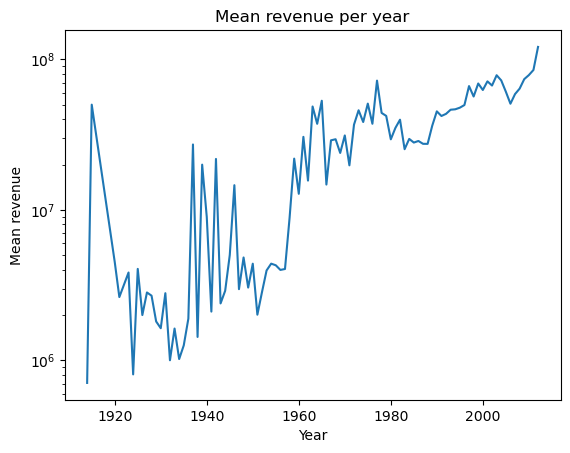

In [13]:

plt.semilogy(mean_revenue_year)
plt.title("Mean revenue per year")
plt.xlabel("Year")
plt.ylabel("Mean revenue")
plt.show()


### Add rotten tomatoes critic score

In [14]:
def processing_rotten_tomatoes_score():
    rotten_movies = pd.read_csv('data/rotten_tomatoes_movies.csv', sep=',', header=0)

    rotten_movies.drop('rotten_tomatoes_link', axis=1, inplace=True)
    rotten_movies.drop('movie_info', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_status', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_count', axis=1, inplace=True)
    rotten_movies.drop('audience_status', axis=1, inplace=True)
    rotten_movies.drop('audience_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_top_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_fresh_critics_count', axis=1, inplace=True)
    rotten_movies.drop('tomatometer_rotten_critics_count', axis=1, inplace=True)
    # rotten_movies.drop('original_release_date', axis=1, inplace=True)
    rotten_movies.drop('streaming_release_date', axis=1, inplace=True)
    rotten_movies.drop('runtime', axis=1, inplace=True)
    rotten_movies.drop('genres', axis=1, inplace=True)
    rotten_movies.drop('content_rating', axis=1, inplace=True)
    rotten_movies.drop('actors', axis=1, inplace=True)

    rotten_movies.dropna(subset=['movie_title', 'audience_rating', 'tomatometer_rating'], inplace=True)
    return rotten_movies

rotten_movies = processing_rotten_tomatoes_score()
joined_movies = movies.join(rotten_movies.set_index('movie_title'), on='Movie name', how='inner')


# 8k film to only 6k
# The are error on the merge => the sorcerer's apprentice is not the same movie
# Need to fixed, maybe using the release date

In [15]:
movies = joined_movies

## Analysis

In [16]:
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,{English Language},{United States of America},"{Musical, Comedy, Black-and-white}",1938,2.516221,True,NaN,Henry King,"Lamar Trotti, Kathryn Scola, Irving Berlin, Ri...",1938-08-16,20th Century Fox Film Corporation,80.0,46.0
13,171005,Henry V,1989-11-08,10161099.0,137.0,{English Language},{United Kingdom},"{Film adaptation, Period piece, War film, Dram...",1989,0.280666,False,Pehaps Kenneth Branagh's most fully realized S...,Kenneth Branagh,Kenneth Branagh,1989-11-08,MGM Home Entertainment,100.0,89.0
17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,{English Language},{United States of America},"{Family Film, Comedy, Children's/Family, Drama...",1964,2.742002,True,A lavish modern fairy tale celebrated for its ...,Robert Stevenson,"Don DaGradi, Bill Walsh",1964-08-26,Walt Disney Productions,100.0,86.0
29,156558,Baby Boy,2001-06-27,29381649.0,123.0,{English Language},{United States of America},"{Coming of age, Drama, Crime Fiction}",2001,0.411379,False,"Preachy and repetitive in parts, Baby Boy stil...",John Singleton,John Singleton,2001-06-27,Columbia Pictures,71.0,87.0
49,261237,The Gods Must Be Crazy,1980-01-01,34331783.0,109.0,"{Afrikaans Language, English Language}",{South Africa},"{Adventure Comedy, Indie, Comedy, Slapstick, A...",1980,1.166923,False,NaN,Jamie Uys,Jamie Uys,1980-01-01,20th Century Fox Film Corporat,85.0,84.0


In [17]:
characters.head()

,Wikipedia movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0


In [18]:
movies[movies["Movie box office revenue"]>1e7].sort_values(by=["audience_rating", "tomatometer_rating"], ascending=False).head(20)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating
36402,2466773,The Godfather,1972-03-15,268500000.0,177.0,"{Latin Language, Italian Language, English Lan...",{United States of America},"{Crime Drama, Gangster Film, Film adaptation, ...",1972,7.292592,True,One of Hollywood's greatest critical and comme...,Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo",1972-03-24,Paramount Pictures,98.0,98.0
26366,30625,The Shawshank Redemption,1994-09-10,28341469.0,142.0,{English Language},{United States of America},"{Buddy film, Drama, Prison, Escape Film, Crime...",1994,0.608585,False,"The Shawshank Redemption is an uplifting, deep...",Frank Darabont,Frank Darabont,1994-09-10,Columbia Pictures,91.0,98.0
25386,65834,Schindler's List,1993-11-30,321306305.0,186.0,"{German Language, Hebrew Language, French Lang...",{United States of America},"{Biographical film, History, Film adaptation, ...",1993,6.944183,True,Schindler's List blends the abject horror of t...,Steven Spielberg,Steven Zaillian,1993-12-15,Universal Pictures,97.0,97.0
59261,31557,"The Good, the Bad and the Ugly",1966-12-23,25100000.0,177.0,"{Italian Language, English Language}","{Spain, West Germany, Italy}","{Action, Western, Spaghetti Western, Revisioni...",1966,1.704413,True,Arguably the greatest of the spaghetti western...,Sergio Leone,"Sergio Leone, Luciano Vincenzoni, Furio Scarpe...",1966-12-23,United Artists,97.0,97.0
78722,2812852,Love Jones,1997-03-14,12782749.0,108.0,{English Language},{United States of America},"{Indie, Romance Film, Comedy, Comedy-drama, Ro...",1997,0.192424,False,NaN,Theodore Witcher,Theodore Witcher,1997-03-14,New Line Home Entertainment,73.0,97.0
9952,1897341,The Pianist,2002-05-24,120072577.0,142.0,"{Russian Language, German Language, English La...","{Poland, United Kingdom, France, Germany}","{Biographical film, History, Drama, War film}",2002,1.792322,True,"Well-acted and dramatically moving, The Pianis...",Roman Polanski,Ronald Harwood,2002-12-27,Focus Features,95.0,96.0
47117,21913863,One Flew Over the Cuckoo's Nest,1975-11-19,108981275.0,129.0,{English Language},{United States of America},"{Tragicomedy, Film adaptation, Tragedy, Indie,...",1975,2.145094,True,The onscreen battle between Jack Nicholson and...,Milos Forman,"Bo Goldman, Lawrence Hauben",1975-11-19,United Artists,94.0,96.0
11421,5454803,The Lives of Others,2006-03-15,11286112.0,137.0,{German Language},{Germany},"{Political thriller, Period piece, Political d...",2006,0.222516,False,"Unlike more traditional spy films, The Lives o...",Florian Henckel von Donnersmarck,Florian Henckel von Donnersmarck,2006-03-23,Sony Pictures Classics,93.0,96.0
66299,54173,Pulp Fiction,1994-01-01,213928762.0,168.0,"{French Language, Spanish Language, English La...",{United States of America},"{Gangster Film, Crime Comedy, Indie, Black com...",1994,4.593760,True,One of the most influential films of the 1990s...,Quentin Tarantino,"Quentin Tarantino, Roger Avary",1994-09-23,Miramax Films,92.0,96.0
27273,167857,The Usual Suspects,1994-01-01,23272306.0,108.0,"{French Language, Spanish Language, Hungarian ...","{United States of America, Germany}","{Crime Thriller, Thriller, Mystery, Ensemble F...",1994,0.499734,False,"Expertly shot and edited, The Usual Suspects g...",Bryan Singer,"Christopher McQuarrie, Bryan Singer",1995-08-16,Gramercy Pictures,89.0,96.0


# Economic success

We load economics data to compare the movie box office return through history. Furthermore, we analyse if economics data are related with success for some year 

In [19]:
!pip install yfinance

In [20]:
import yfinance

financial_indicator = yfinance.download("^GSPC", start = pd.to_datetime(movies["Movie Year Release"].min(), format="%Y"), end=pd.to_datetime(movies["Movie Year Release"].max(), format="%Y"))



[*********************100%%**********************]  1 of 1 completed


In [21]:
pd.to_datetime(movies["Movie Year Release"].min(), format="%Y")
financial_indicator["Close"]/financial_indicator["Close"][0]


Date
1927-12-30     1.000000
1928-01-03     1.005663
1928-01-04     1.003397
1928-01-05     0.993771
1928-01-06     1.000000
                ...    
2011-12-23    71.649489
2011-12-27    71.655157
2011-12-28    70.761043
2011-12-29    71.518688
2011-12-30    71.211777
Name: Close, Length: 21097, dtype: float64

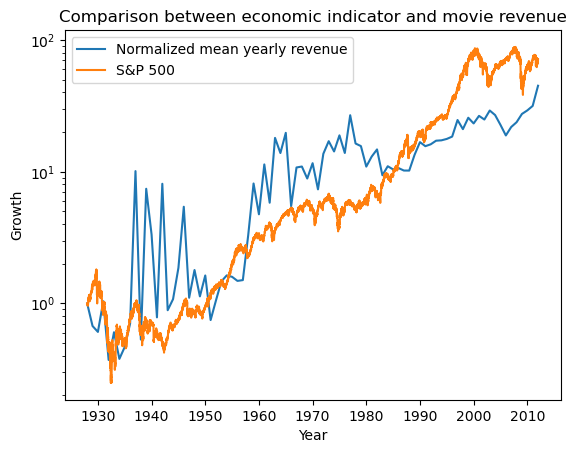

In [22]:
financial_revenue_year = mean_revenue_year[mean_revenue_year.index>financial_indicator.index.year.min()]
financial_revenue_year.index = pd.to_datetime(financial_revenue_year.index, format="%Y") 
plt.semilogy(financial_revenue_year/financial_revenue_year[0], label="Normalized mean yearly revenue")
plt.semilogy(financial_indicator["Close"]/financial_indicator["Close"][0], label="S&P 500")
plt.title("Comparison between economic indicator and movie revenue")
plt.xlabel("Year")
plt.ylabel("Growth")
plt.legend()
plt.show()

## Analysis of inflation

In [23]:
!pip install cpi

In [24]:
import cpi

cpi_df = cpi.series.get().to_dataframe()
cpi_df = cpi_df[cpi_df['period_type']=='monthly']
cpi_df['date'] = pd.to_datetime(cpi_df['date'])
cpi_df = cpi_df.set_index('date').sort_values(by="date")

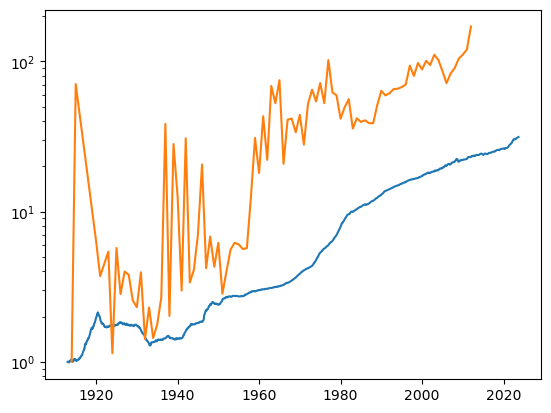

In [25]:
#inflation = cpi_df[(cpi_df.index>financial_revenue_year)]
mean_revenue_year.index = pd.to_datetime(mean_revenue_year.index, format="%Y")
plt.semilogy(cpi_df["value"]/(cpi_df["value"].iloc[0]))
plt.semilogy(mean_revenue_year/mean_revenue_year.iloc[0])


### Adjust the effect of inflation on the movie revenue

In [26]:
mean_revenue_year.iloc[0]

707932.0

In [27]:
movies["Inflated revenue"]=movies.apply(lambda x: cpi.inflate(x["Movie box office revenue"], x["Movie Year Release"]), axis=1)

In [28]:
movies.sort_values(by=["Movie Year Release","Inflated revenue"], ascending=[True, False]).head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie Year Release,Normalized revenue,Success,critics_consensus,directors,authors,original_release_date,production_company,tomatometer_rating,audience_rating,Inflated revenue
53319,15340505,Neptune's Daughter,1914-04-25,1000000.0,NaN,{English Language},{United States of America},"{Silent film, Indie, Black-and-white}",1914,1.412565,False,NaN,Edward Buzzell,"Dick Chevillat, Dorothy Kingsley, Ray Singer",1949-06-01,MGM Home Entertainment,100.0,59.0,2.926550e+07
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{Silent film, English Language}",{United States of America},"{Indie, Black-and-white, Drama, Epic, Costume ...",1915,1.000000,False,"A deeply flawed cinematic landmark, The Birth ...",D.W. Griffith,"Frank Woods, D.W. Griffith, Frank E. Woods, Th...",1915-03-03,Gravitas,93.0,56.0,1.448787e+09
2634,3333,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{Silent film, English Language}",{United States of America},"{Indie, Black-and-white, Drama, Epic, Costume ...",1915,1.000000,False,The Birth of a Nation overpowers its narrative...,Nate Parker,"Nate Parker, Jean McGianni Celestin",2016-10-07,Fox Searchlight Pictures,72.0,71.0,1.448787e+09
24953,4499436,Way Down East,1920-01-01,4500000.0,147.0,"{Silent film, English Language}",{United States of America},"{Indie, Romance Film, Western, Romantic drama,...",1920,1.000000,False,NaN,D.W. Griffith,"D.W. Griffith, Anthony Paul Kelly",1920-09-03,Kino Lorber,95.0,69.0,6.584737e+07
40247,1346905,The Kid,1921-01-01,2500000.0,60.0,"{Silent film, English Language}",{United States of America},"{Silent film, Indie, Comedy, Drama, Black-and-...",1921,0.949367,False,Charles Chaplin' irascible Tramp is given able...,Charles Chaplin,Charles Chaplin,1921-01-21,First National Pictures Inc.,100.0,95.0,4.087360e+07


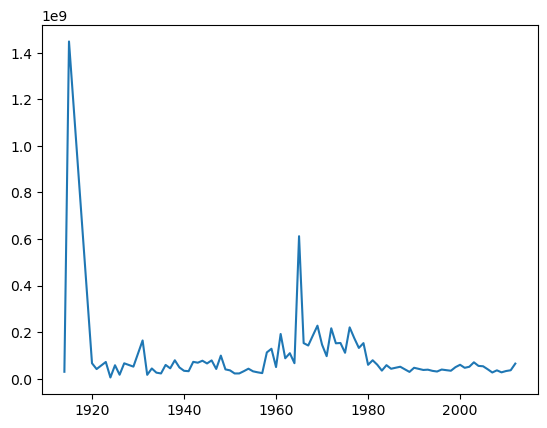

In [29]:
mean_infl_revenue_year = movies.groupby('Movie Year Release')['Inflated revenue'].median()
plt.plot(mean_infl_revenue_year)

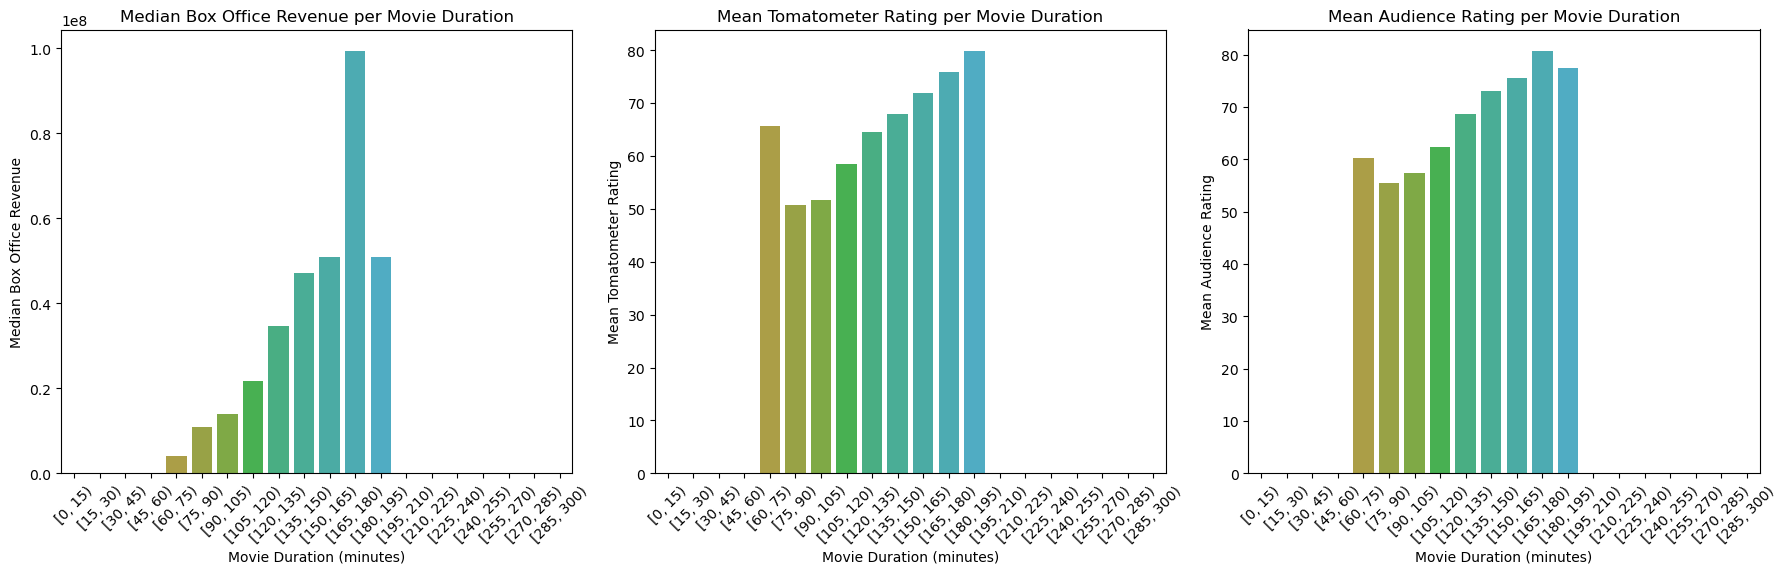

In [71]:
# Convert 'Movie release date' to datetime
movies['Movie release date'] = pd.to_datetime(movies['Movie release date'])

# Extract month and year from the release date
movies['Month'] = movies['Movie release date'].dt.month
movies['Year'] = movies['Movie release date'].dt.year

# Create bins for movie length with a step of 15 minutes up to 300 minutes
bins = list(range(0, 315, 15))

# Assign movies to bins based on Movie Length
movies['Length Bin'] = pd.cut(movies['Movie runtime'], bins=bins, right=False)

# Filter out bins with a small sample size (adjust the threshold as needed)
min_sample_size = 25
valid_bins = movies['Length Bin'].value_counts()[movies['Length Bin'].value_counts() >= min_sample_size].index
filtered_movies = movies[movies['Length Bin'].isin(valid_bins)]

# Group by the length bins and calculate the median of Box Office Revenue, Tomatometer Rating, and Audience Rating for each bin
grouped_data = filtered_movies.groupby('Length Bin').agg({
    'Movie box office revenue': 'median',
    'tomatometer_rating': 'mean',
    'audience_rating': 'mean'
}).reset_index()

# Plotting the median box office revenue per movie duration
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Length Bin', y='Movie box office revenue', data=grouped_data)
plt.title('Median Box Office Revenue per Movie Duration')
plt.xlabel('Movie Duration (minutes)')
plt.ylabel('Median Box Office Revenue')
plt.xticks(rotation=45)

# Plotting tomatometer_rating per movie duration
plt.subplot(1, 3, 2)
sns.barplot(x='Length Bin', y='tomatometer_rating', data=grouped_data)
plt.title('Mean Tomatometer Rating per Movie Duration')
plt.xlabel('Movie Duration (minutes)')
plt.ylabel('Mean Tomatometer Rating')
plt.xticks(rotation=45)

# Plotting audience_rating per movie duration
plt.subplot(1, 3, 3)
sns.barplot(x='Length Bin', y='audience_rating', data=grouped_data)
plt.title('Mean Audience Rating per Movie Duration')
plt.xlabel('Movie Duration (minutes)')
plt.ylabel('Mean Audience Rating')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Movie Duration Graph Analysis & Comparison

A common trend in all 3 graphs is the strict increase of 'success' from the 75-90' movie bucket to the 165-180' movie bucket. We only considered buckets with a large enough sample size to provide more useful insight, a minimum threshold of 25 movie occurrences. Extreme values of box office revenues could heavily influence the mean, so we took the median as we have a big enough sample size and more importantly unskewed data.

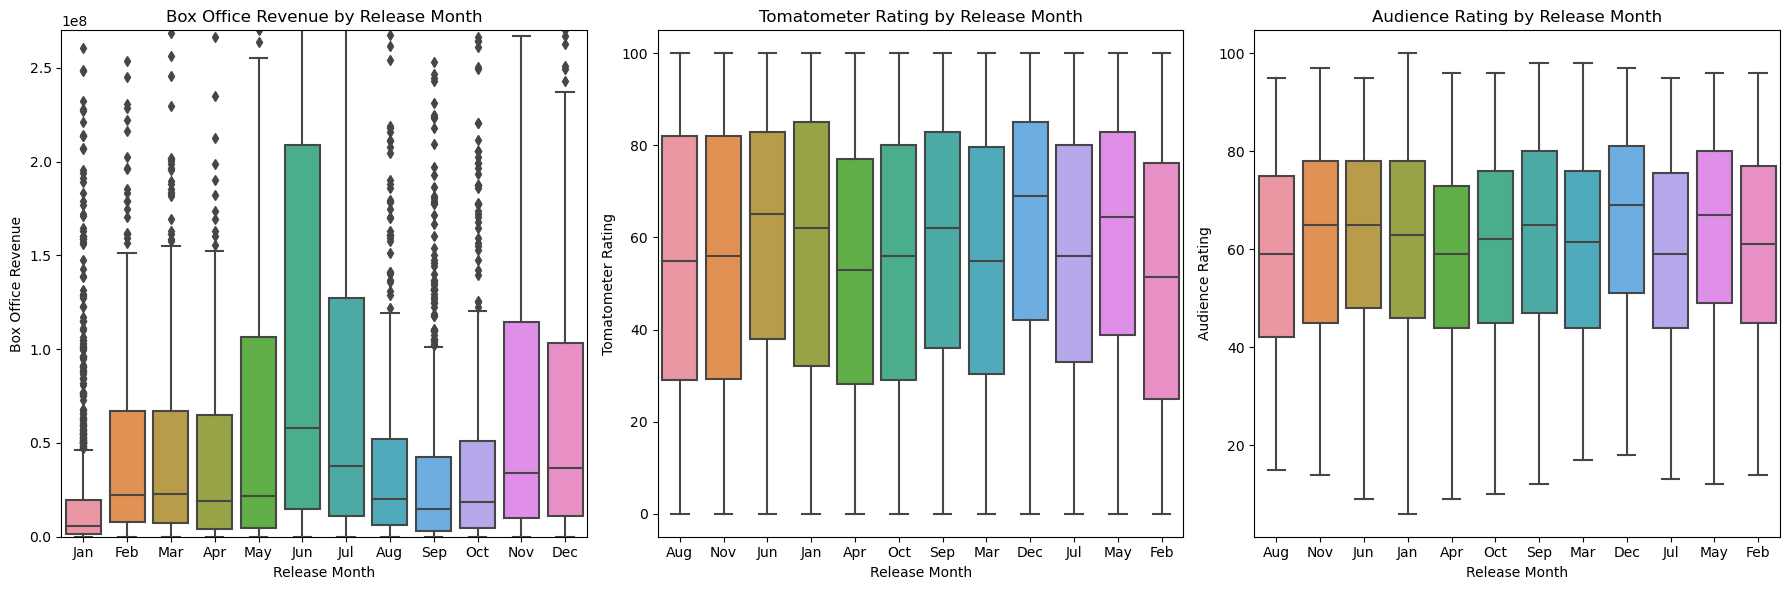

In [72]:
# Explore the relationship between movie month release and box office revenue

# Specify the order of months for plotting
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Map the numeric month values to month names
movies['Month'] = list(map(lambda x: month_order[x - 1], movies['Month']))

plt.figure(figsize=(18, 6))

# Plotting the relationship between movie month release and box office revenue
plt.subplot(1, 3, 1)
sns.boxplot(x='Month', y='Movie box office revenue', data=movies,order=month_order)
plt.title('Box Office Revenue by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Box Office Revenue')
plt.ylim(0, 2.7e8)  # Set y-axis limits for box office revenue

# Plotting tomatometer_rating per movie duration
plt.subplot(1, 3, 2)
sns.boxplot(x='Month', y='tomatometer_rating', data=movies)
plt.title('Tomatometer Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Tomatometer Rating')

# Plotting audience_rating per movie duration
plt.subplot(1, 3, 3)
sns.boxplot(x='Month', y='audience_rating', data=movies)
plt.title('Audience Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Audience Rating')

plt.tight_layout()
plt.show()

### Release Month Graph Analysis & Comparison

It makes sense that there is no significant relation between movie ratings and release month. The interesting plot here is the box office revenue per release month. June, July, November and December are clearly the most profitable movie release months, most likely due to the holiday seasons that can attract more viewers to cinemas. We also notice that the months that follow the holiday season are extremely unprofitable for movie releases, notably January and September: students go back to school after the summer/christmas holidays and general consumers may want to spend less money after their holiday expenses. 